# Calculating Hedge Ratios for Cash Curve and Fly Trades

In [1]:
import sys
sys.path.append("../")

import pandas as pd
from datetime import datetime 

from CurvyCUSIPs.CurveInterpolator import GeneralCurveInterpolator
from CurvyCUSIPs.CurveDataFetcher import CurveDataFetcher
from CurvyCUSIPs.USTs import USTs
from CurvyCUSIPs.utils.pca_utils import calc_pca_loadings_matrix
from CurvyCUSIPs.utils.regression_utils import run_basic_linear_regression
from CurvyCUSIPs.HedgeHog import dv01_neutral_curve_hedge_ratio, dv01_neutral_butterfly_hedge_ratio, beta_estimates

import os
from dotenv import dotenv_values
env_path = os.path.join(os.getcwd(), "../.env")
config = dotenv_values(env_path)

import nest_asyncio
nest_asyncio.apply()

%load_ext autoreload
%autoreload 2

In [2]:
curve_data_fetcher = CurveDataFetcher(use_ust_issue_date=True, fred_api_key=config["FRED_API_KEY"])
usts = USTs(
    cusip_set_db_path=r"..\db\ust_cusip_set",
    cusip_timeseries_db_path=r"..\db\ust_cusip_timeseries",
    ct_eod_db_path=r"..\db\ust_eod_ct_yields",
    curve_data_fetcher=curve_data_fetcher,
)

..\db\ust_cusip_set is behind --- cd into 'scripts' and run 'update_ust_cusips_db.py' to update --- most recent date in db: 2024-12-30 00:00:00


In [3]:
tenors = ["CT3M", "CT6M", "CT1", "CT2", "CT3", "CT5", "CT7", "CT10", "CT20", "CT30"]
bid_ct_yields_df = usts.fetch_ct_yields(start_date=datetime(2024, 1, 1), end_date=datetime(2024, 12, 20), use_offer_side=True)
offer_ct_yields_df = usts.fetch_ct_yields(start_date=datetime(2024, 1, 1), end_date=datetime(2024, 12, 20), use_bid_side=True)
bid_offer_spread_ct_yields_df: pd.DataFrame = bid_ct_yields_df - offer_ct_yields_df
display(bid_offer_spread_ct_yields_df)

eod_ct_yields_df: pd.DataFrame = usts.fetch_ct_yields(start_date=datetime(2024, 1, 1), end_date=datetime(2024, 12, 20)) 
eod_ct_yields_df

,CT3M,CT6M,CT1,CT2,CT3,CT5,CT7,CT10,CT20,CT30
Date,,,,,,,,,,
2024-01-02,-0.010376,-0.010578,-0.016514,0.000000,0.000000,-0.003485,-0.002566,-0.001874,-0.001121,-0.000840
2024-01-03,-0.015558,-0.010574,-0.011009,0.000000,0.000000,0.000000,-0.002600,-0.001880,-0.001128,-0.000848
2024-01-04,-0.005183,-0.005284,-0.005505,0.000000,0.000000,0.000000,-0.002605,-0.001884,-0.001131,-0.000852
2024-01-05,-0.010620,-0.005351,-0.011059,0.000000,0.000000,0.000000,0.000000,0.000000,-0.001136,-0.000857
2024-01-08,-0.005191,-0.005290,-0.016488,0.000000,0.000000,0.000000,-0.002604,-0.001885,-0.001132,-0.000856
...,...,...,...,...,...,...,...,...,...,...
2024-12-16,-0.005162,-0.005243,-0.005433,0.000000,-0.005767,0.000000,0.000000,-0.001977,-0.001225,-0.000984
2024-12-17,-0.005161,-0.005240,-0.005430,0.000000,0.000000,-0.003544,0.000000,-0.001974,-0.001216,-0.000974
2024-12-18,-0.005164,-0.005240,-0.005428,0.000000,0.000000,0.000000,-0.002644,0.000000,-0.001221,-0.000976


,CT3M,CT6M,CT1,CT2,CT3,CT5,CT7,CT10,CT20,CT30
Date,,,,,,,,,,
2024-01-02,5.295390,5.177835,4.787577,4.370389,4.100865,3.928581,3.961901,3.944570,4.247731,4.083522
2024-01-03,5.304862,5.187600,4.797913,4.332576,4.077939,3.895921,3.914869,3.906943,4.210063,4.053253
2024-01-04,5.293835,5.186854,4.830198,4.382398,4.145585,3.972914,3.992895,3.989457,4.295486,4.137732
2024-01-05,5.307206,5.180070,4.828254,4.399235,4.178916,4.015292,4.040103,4.049632,4.363723,4.208215
2024-01-08,5.306426,5.168807,4.805679,4.365890,4.121773,3.966166,3.993101,4.011612,4.322542,4.177047
...,...,...,...,...,...,...,...,...,...,...
2024-12-16,4.273180,4.267709,4.224859,4.248217,4.226354,4.244316,4.318720,4.390361,4.675722,4.602047
2024-12-17,4.282876,4.267204,4.235190,4.248107,4.224416,4.258507,4.324040,4.395133,4.673271,4.586854
2024-12-18,4.272166,4.256278,4.278011,4.349364,4.348871,4.393786,4.451621,4.494405,4.754284,4.649719


In [4]:
date = datetime(2024, 12, 20)
curve_set_df: pd.DataFrame = usts.fetch_historical_curve_sets(start_date=date, calc_free_float=True)[date]

otr_df: pd.DataFrame = curve_set_df[curve_set_df["rank"] == 0].sort_values(by="time_to_maturity")

curve_set_filtered_df = curve_set_df[
    (curve_set_df["rank"] != 0)
    & (curve_set_df["rank"] != 1)
    & (curve_set_df["rank"] != 2)
    & (curve_set_df["rank"] != 3)
]
curve_set_filtered_df = curve_set_filtered_df[
    curve_set_filtered_df["security_type"] != "Bill"
]
curve_set_filtered_df = curve_set_filtered_df[
    curve_set_filtered_df["free_float"] > 5000
]
curve_set_filtered_df = curve_set_filtered_df[
    curve_set_filtered_df["time_to_maturity"] > 30 / 360
]
curve_set_filtered_df = curve_set_filtered_df.sort_values(by=["time_to_maturity"])

quote_type = "eod"
filtered_fitted_interpolator = GeneralCurveInterpolator(
    x=curve_set_filtered_df["time_to_maturity"].to_numpy(),
    y=curve_set_filtered_df[f"{quote_type}_yield"].to_numpy(),
)
fitted_bspline = filtered_fitted_interpolator.b_spline_with_knots_interpolation(
    knots=[0.5, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 15, 20, 25],
    k=3,
    return_func=True,
)

AGGREGATING CURVE SET DFs: 100%|██████████| 1/1 [00:00<00:00, 10.42it/s]


# Curves

In [5]:
ct2_row = otr_df[otr_df["original_security_term"] == "2-Year"]
ct5_row = otr_df[otr_df["original_security_term"] == "5-Year"]
ct10_row = otr_df[otr_df["original_security_term"] == "10-Year"]

curve_pca_results = calc_pca_loadings_matrix(
    df=eod_ct_yields_df, 
    cols=["CT2", "CT10"], 
    run_on_level_changes=True,
    scale_loadings=True 
)
display(curve_pca_results)

curve_beta_estimates_results = beta_estimates(
    df=eod_ct_yields_df.reset_index(),
    x_cols=["CT2"],
    y_col="CT10",
    run_on_level_changes=True,
    loadings_df=curve_pca_results["loading_matrix"],
    x_errs=bid_offer_spread_ct_yields_df["CT2"].to_numpy(),
    y_errs=bid_offer_spread_ct_yields_df["CT10"].to_numpy(),
)

curve_beta_estimates_results["betas"]

{'pca': PCA(),
 'loading_matrix':            PC1       PC2
 CT2   0.083318 -0.020907
 CT10  0.077062  0.022604,
 'pc_scores_matrix':           Date       PC1       PC2   PC3
 0   2024-01-03 -0.054689  0.003874  None
 1   2024-01-04  0.091222 -0.024819  None
 2   2024-01-05  0.051839 -0.030817  None
 3   2024-01-08 -0.051676  0.007197  None
 4   2024-01-09  0.001128 -0.000738  None
 ..         ...       ...       ...   ...
 239 2024-12-16 -0.004136  0.004742  None
 240 2024-12-17  0.001779 -0.001651  None
 241 2024-12-18  0.140361 -0.002197  None
 242 2024-12-19  0.025465 -0.076927  None
 243 2024-12-20 -0.049207  0.028547  None
 
 [244 rows x 4 columns],
 'covar_matrix':             CT2       CT10
 CT2   73.789914  59.481049
 CT10  59.481049  64.495238}

c:\Users\chris\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


{'ols': np.float64(0.8060864391974295),
 'tls': np.float64(0.9249101957800931),
 'odr': np.float64(nan),
 'pc1': np.float64(1.0811790226389426),
 'box_tiao': [np.float64(0.37593608196670847)],
 'johansen': [0.27474491390784256],
 'minimum_half_life': [np.float64(0.3813504506674917)],
 'adf_optimal': [np.float64(0.2716374288490576)]}

In [7]:
dv01_neutral_curve_hedge_ratio(
    usts_obj=usts,
    as_of_date=date,
    front_leg_bond_row=ct2_row,
    back_leg_bond_row=ct10_row,
    scipy_interp_curve=fitted_bspline,
    repo_rate=4.5,
    yvx_beta_adjustment=curve_beta_estimates_results["betas"]["pc1"],
    back_leg_par_amount=10_000_000,
)

2s10s
4.250% Nov-26 / 4.250% Nov-34
Beta Weighted Hedge Ratio: 4.597876
Front Leg: 4.250% Nov-26 (OST 2-Year, TTM = 1.945205) Par Amount = 45_978_758.751290314
Back Leg: 4.250% Nov-34 (OST 10-Year, TTM = 9.909589) Par Amount = 10_000_000
Total Trade Par Amount: 55_978_758.751290314


{'current_spread': 22.000994927431172,
 'current_bpv_neutral_spread': -1376.1487761192184,
 'current_beta_weighted_spread': np.float64(-1524.543966155503),
 'rough_3m_impl_fwd_spread': np.float64(12.197468921730614),
 'rough_6m_impl_fwd_spread': np.float64(10.95825115387088),
 'rough_12m_impl_fwd_spread': np.float64(12.084290888183613),
 'front_leg_metrics': {'Date': datetime.datetime(2024, 12, 20, 0, 0),
  'zspread': -8.053872227621559,
  'zspread_impl_clean_price': 99.94711601006398,
  'clean_price': 99.91320487056329,
  'dirty_price': 99.81294934349086,
  'accrued_amount': 0.011612021857931865,
  'bps': -0.018355234966897515,
  'dv01_1mm': -183.55234966897515,
  'mac_duration': 1.8791186379771947,
  'mod_duration': 1.8395814836562714,
  'convexity': 4.334007855679739,
  'basis_point_value': -0.018355234966897515,
  'yield_value_basis_point': -5.4480306141581954e-05,
  'rough_carry': -0.20150551392362814,
  'rough_3m_rolldown': np.float64(-0.2922356126348724),
  'rough_6m_rolldown': 

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                      -0.000
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                -2.689e-14
Date:                Thu, 02 Jan 2025   Prob (F-statistic):               1.00
Time:                        09:09:53   Log-Likelihood:                 409.08
No. Observations:                 244   AIC:                            -814.2
Df Residuals:                     242   BIC:                            -807.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0028      0.003      0.976      0.3

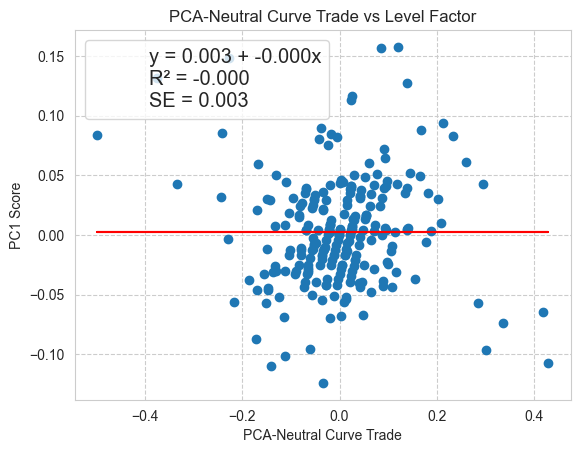

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.896e+33
Date:                Thu, 02 Jan 2025   Prob (F-statistic):               0.00
Time:                        09:09:53   Log-Likelihood:                 9139.4
No. Observations:                 244   AIC:                        -1.827e+04
Df Residuals:                     242   BIC:                        -1.827e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0028   8.41e-19   3.37e+15      0.0

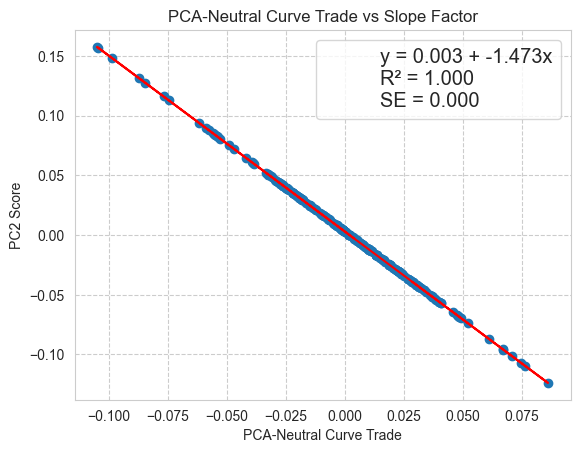

In [8]:
curve_diff = eod_ct_yields_df.diff().dropna()
curve_diff = (curve_diff["CT10"] * curve_beta_estimates_results["betas"]["pc1"]  - curve_diff["CT2"])

run_basic_linear_regression(
    x_series=curve_pca_results["pc_scores_matrix"]["PC1"],
    y_series=curve_diff.values,
    x_label="PC1 Score",
    y_label="PCA-Neutral Curve Trade",
    title="PCA-Neutral Curve Trade vs Level Factor",
)

run_basic_linear_regression(
    x_series=curve_pca_results["pc_scores_matrix"]["PC2"],
    y_series=curve_diff.values,
    x_label="PC2 Score",
    y_label="PCA-Neutral Curve Trade",
    title="PCA-Neutral Curve Trade vs Slope Factor",
)


# Butterflies

In [9]:
ct2_row = otr_df[otr_df["original_security_term"] == "2-Year"]
ct5_row = otr_df[otr_df["original_security_term"] == "5-Year"]
ct10_row = otr_df[otr_df["original_security_term"] == "10-Year"]

fly_pca_results = calc_pca_loadings_matrix(
    df=eod_ct_yields_df, 
    cols=["CT2", "CT5", "CT10"], 
    run_on_level_changes=True,
    scale_loadings=True 
)
display(fly_pca_results)

fly_beta_estimates_results = beta_estimates(
    df=eod_ct_yields_df.reset_index(),
    x_cols=["CT2", "CT10"],
    y_col="CT5",
    run_on_level_changes=True,
    pc_scores_df=fly_pca_results["pc_scores_matrix"],
    loadings_df=fly_pca_results["loading_matrix"],
)
fly_beta_estimates_results["betas"]

{'pca': PCA(),
 'loading_matrix':            PC1       PC2       PC3
 CT2   0.082692  0.023136 -0.002383
 CT5   0.087351 -0.003698  0.005530
 CT10  0.077560 -0.020502 -0.003687,
 'pc_scores_matrix':           Date       PC1       PC2       PC3
 0   2024-01-03 -0.064387 -0.002541 -0.006536
 1   2024-01-04  0.118277  0.024475 -0.000100
 2   2024-01-05  0.065987  0.030164  0.004212
 3   2024-01-08 -0.072067 -0.008077  0.007663
 4   2024-01-09  0.004116  0.001245 -0.003337
 ..         ...       ...       ...       ...
 239 2024-12-16 -0.013048 -0.006175  0.009283
 240 2024-12-17  0.008968  0.002926 -0.008363
 241 2024-12-18  0.192650  0.004211 -0.019637
 242 2024-12-19  0.041370  0.077543  0.000539
 243 2024-12-20 -0.075010 -0.030345  0.011994
 
 [244 rows x 4 columns],
 'covar_matrix':             CT2        CT5       CT10
 CT2   73.789914  71.245061  59.481049
 CT5   71.245061  76.743907  68.303729
 CT10  59.481049  68.303729  64.495238}

c:\Users\chris\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


{'ols': [np.float64(0.4358270767466025), np.float64(0.6571070894576327)],
 'tls': [np.float64(0.4309860382823271), np.float64(0.6667247961930799)],
 'odr': None,
 'pc1': [np.float64(0.4309850509997007), np.float64(0.6667258492855243)],
 'box_tiao': [np.float64(0.268630760179303), np.float64(0.8945765192536751)],
 'johansen': [0.2678360149984331, 0.8964905246879012],
 'minimum_half_life': [np.float64(0.2676562760193621),
  np.float64(0.8968568285026663)],
 'adf_optimal': [np.float64(0.2621824920753308),
  np.float64(0.9087631301730403)]}

In [10]:
fly_hr_info_dict = dv01_neutral_butterfly_hedge_ratio(
    usts_obj=usts,
    as_of_date=date,
    front_wing_bond_row=ct2_row,
    belly_bond_row=ct5_row,
    back_wing_bond_row=ct10_row,
    scipy_interp_curve=fitted_bspline,
    repo_rate=4.83,
    yvx_front_wing_beta_adjustment=fly_beta_estimates_results["betas"]["pc1"][1],
    yvx_back_wing_beta_adjustment=fly_beta_estimates_results["betas"]["pc1"][0],
    back_wing_par_amount=10_000_000,
)
fly_hr_info_dict

2s5s10s
4.250% Nov-26 - 4.125% Nov-29 - 4.250% Nov-34 Fly
BPV Neutral Hedge Ratio:
{
    "front_wing_hr": 1.1895130563578258,
    "belly_hr": 1,
    "back_wing_hr": 0.27971102278900123
}
Beta Weighted Hedge Ratio:
{
    "front_wing_hr": 0.793079102736391,
    "belly_hr": 1,
    "back_wing_hr": 0.12055126942189613
}
Front Wing: 4.250% Nov-26 (OST 2-Year, TTM = 1.945205) Par Amount = 65_787_702.32280453
Belly: 4.125% Nov-29 (OST 5-Year, TTM = 4.947945) Par Amount = 82_952_257.97252092
Back Wing: 4.250% Nov-34 (OST 10-Year, TTM = 9.909589) Par Amount = 10_000_000
Total Trade Par Amount: 158_739_960.29532546
Risk Weights - Front Wing: 66.673%, Back Wing: 43.099%, Sum: 109.771%


{'curr_spread': -7.162787074065946,
 'rough_3m_impl_fwd_spread': np.float64(5.268212581144294),
 'rough_6m_impl_fwd_spread': np.float64(4.993800958872807),
 'rough_12m_impl_fwd_spread': np.float64(6.7682764550462515),
 'front_wing_metrics': {'Date': datetime.datetime(2024, 12, 20, 0, 0),
  'zspread': -8.053872227621559,
  'zspread_impl_clean_price': 99.94711601006398,
  'clean_price': 99.91320487056329,
  'dirty_price': 99.81294934349086,
  'accrued_amount': 0.011612021857931865,
  'bps': -0.018355234966897515,
  'dv01_1mm': -183.55234966897515,
  'mac_duration': 1.8791186379771947,
  'mod_duration': 1.8395814836562714,
  'convexity': 4.334007855679739,
  'basis_point_value': -0.018355234966897515,
  'yield_value_basis_point': -5.4480306141581954e-05,
  'rough_carry': -0.5315055139236282,
  'rough_3m_rolldown': np.float64(-0.2922356126348724),
  'rough_6m_rolldown': np.float64(1.5541891362721216),
  'rough_12m_rolldown': np.float64(0.9870451723606344)},
 'belly_metrics': {'Date': datet

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                     0.000
Date:                Thu, 02 Jan 2025   Prob (F-statistic):               1.00
Time:                        09:10:11   Log-Likelihood:                 803.25
No. Observations:                 244   AIC:                            -1602.
Df Residuals:                     242   BIC:                            -1596.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.001      0.655      0.5

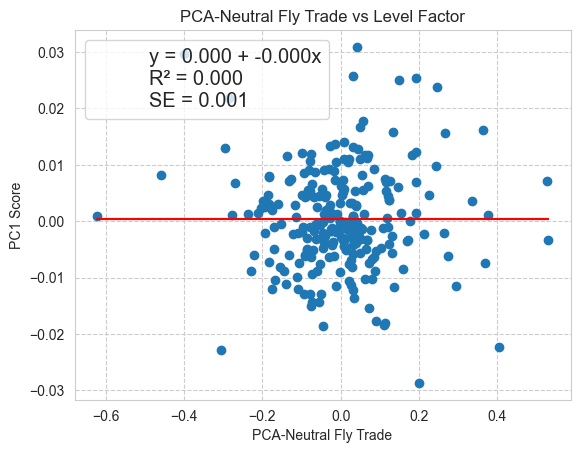

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                      -0.000
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                -4.252e-14
Date:                Thu, 02 Jan 2025   Prob (F-statistic):               1.00
Time:                        09:10:11   Log-Likelihood:                 803.25
No. Observations:                 244   AIC:                            -1602.
Df Residuals:                     242   BIC:                            -1596.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.001      0.655      0.5

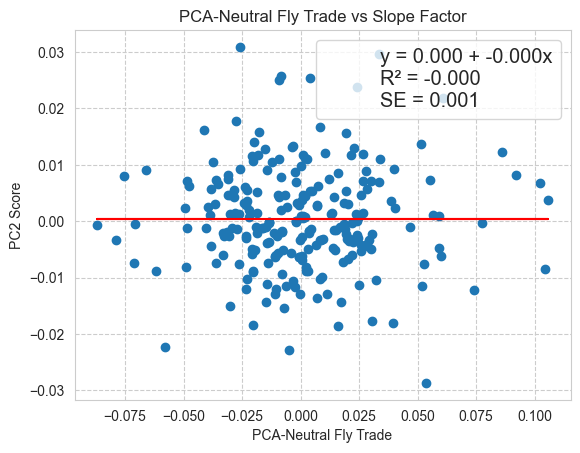

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 7.701e+30
Date:                Thu, 02 Jan 2025   Prob (F-statistic):               0.00
Time:                        09:10:12   Log-Likelihood:                 8810.1
No. Observations:                 244   AIC:                        -1.762e+04
Df Residuals:                     242   BIC:                        -1.761e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004   3.24e-18   1.17e+14      0.0

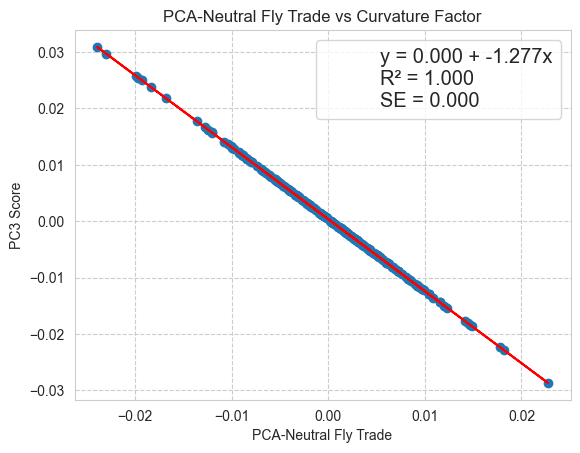

In [11]:
fly_diff = eod_ct_yields_df.diff().dropna()
fly_diff = fly_diff["CT5"] * 1 - (
    fly_beta_estimates_results["betas"]["pc1"][0] * fly_diff["CT2"]
    + fly_beta_estimates_results["betas"]["pc1"][1] * fly_diff["CT10"]
)

run_basic_linear_regression(
    x_series=fly_pca_results["pc_scores_matrix"]["PC1"],
    y_series=fly_diff.values,
    x_label="PC1 Score",
    y_label="PCA-Neutral Fly Trade",
    title="PCA-Neutral Fly Trade vs Level Factor",
)

run_basic_linear_regression(
    x_series=fly_pca_results["pc_scores_matrix"]["PC2"],
    y_series=fly_diff.values,
    x_label="PC2 Score",
    y_label="PCA-Neutral Fly Trade",
    title="PCA-Neutral Fly Trade vs Slope Factor",
)

run_basic_linear_regression(
    x_series=fly_pca_results["pc_scores_matrix"]["PC3"],
    y_series=fly_diff.values,
    x_label="PC3 Score",
    y_label="PCA-Neutral Fly Trade",
    title="PCA-Neutral Fly Trade vs Curvature Factor",
)